In [1]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
from pyabf import ABF
from functools import wraps
from dtw import dtw
from scipy.signal import resample

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



In [2]:
from porepipe import *

In [20]:
abfpath = Path("01_MspAD90N_1MKGlu_10mMMgCl2_Pdb11peo8_Dphph_1_1_37C_clpX_MBP_DDRR_0006.abf")

In [21]:
abf = ABF(abfpath)

In [22]:
fs = abf.sampleRate

In [37]:
squiggles = Pipeline(
    switch(cutoff=15*fs),
    lowpass(cutoff_fq=100, abf=abf),
    as_ires(minsamples=1000),
    trim(left=0.5*fs, right=0.5*fs),
    # at_shapelet(shapelet=prototype, include=False, mindist=8)
)

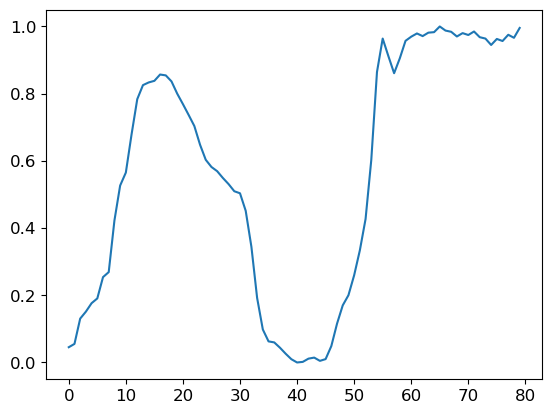

In [38]:
plt.plot(prototype)

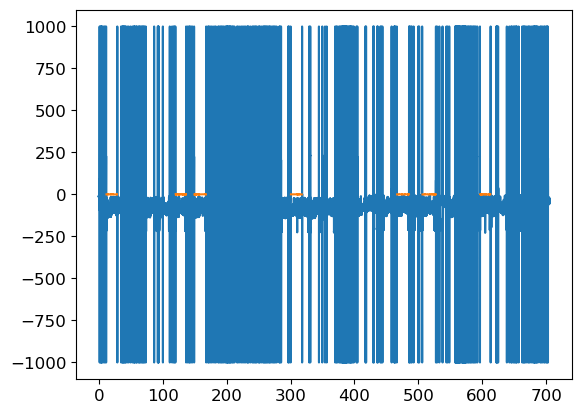

In [39]:
squiggles(abf).by_name['sweep'][0].inspect()

([], [])

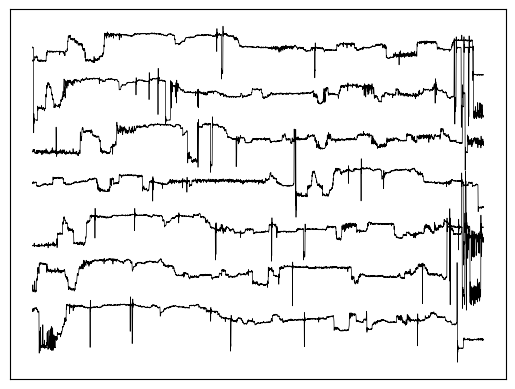

In [40]:
for i, event in enumerate(squiggles(abf).events):
    y = event.y
    t = np.linspace(0,1,len(y))
    # t = event.t
    plt.plot(t,y-1*i,'-k',lw=0.5)
    # break
# plt.ylim((0,1))
plt.yticks([])
plt.xticks([])

In [43]:
tags = []

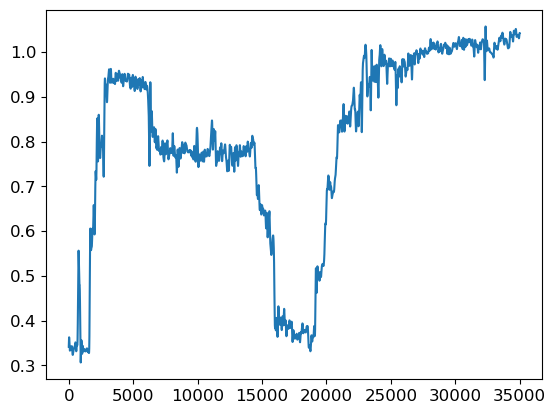

In [44]:
# plt.plot('t','y','-k',data=squiggles(abfpath).events[5])
# plt.xlim((506.5,510))
event = squiggles(abf).events[5]
t = event.t
y = event.y
a = 506.5
b = 510
tag = y[int((a-t[0])*fs):int((b-t[0])*fs)]
plt.plot(tag)
tags.append(tag)

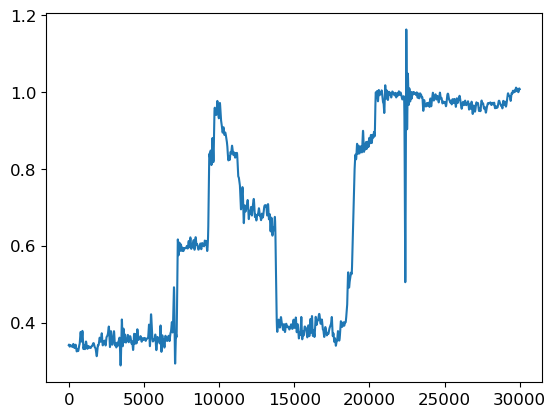

In [46]:
# plt.plot('t','y','-k',data=squiggles(abfpath).events[4])
# plt.xlim((467,470))
event = squiggles(abf).events[4]
t = event.t
y = event.y
a = 467
b = 470
tag = y[int((a-t[0])*fs):int((b-t[0])*fs)]
plt.plot(tag)
tags.append(tag)

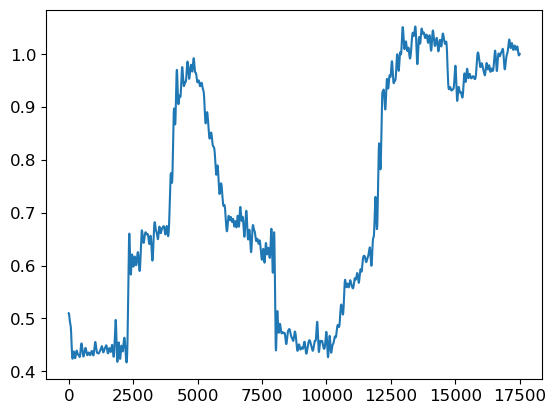

In [47]:
# plt.plot('t','y','-k',data=squiggles(abfpath).events[3])
# plt.xlim((310.75,312.5))
event = squiggles(abf).events[3]
t = event.t
y = event.y
a = 310.75
b = 312.5
tag = y[int((a-t[0])*fs):int((b-t[0])*fs)]
plt.plot(tag)
tags.append(tag)

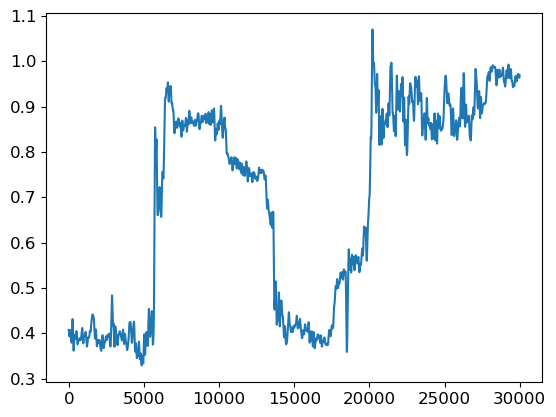

In [48]:
# plt.plot('t','y','-k',data=squiggles(abfpath).events[2])
# plt.xlim((151,154))
event = squiggles(abf).events[2]
t = event.t
y = event.y
a = 151
b = 154
tag = y[int((a-t[0])*fs):int((b-t[0])*fs)]
plt.plot(tag)
tags.append(tag)

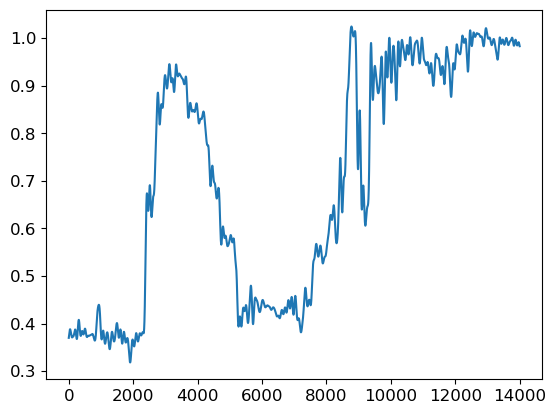

In [49]:
# plt.plot('t','y','-k',data=squiggles(abfpath).events[1])
# plt.xlim((120.6,122))
event = squiggles(abf).events[1]
t = event.t
y = event.y
a = 120.6
b = 122
tag = y[int((a-t[0])*fs):int((b-t[0])*fs)]
plt.plot(tag)
tags.append(tag)

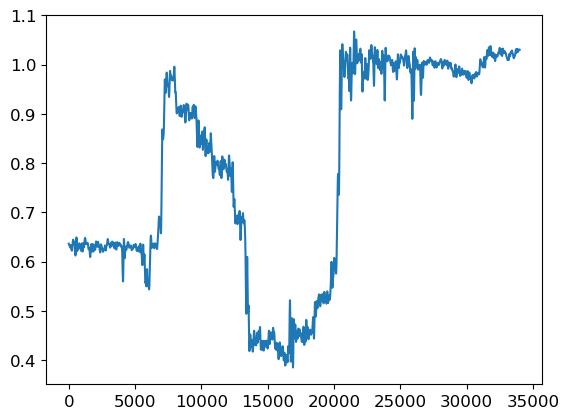

In [50]:
# plt.plot('t','y','-k',data=squiggles(abfpath).events[0])
# plt.xlim((12.6,16))
event = squiggles(abf).events[0]
t = event.t
y = event.y
a = 12.6
b = 16
tag = y[int((a-t[0])*fs):int((b-t[0])*fs)]
plt.plot(tag)
tags.append(tag)

In [51]:
for tag in tags:
    print(len(tag))

35000
30000
17500
30000
14000
34001


In [52]:
from scipy.signal import resample

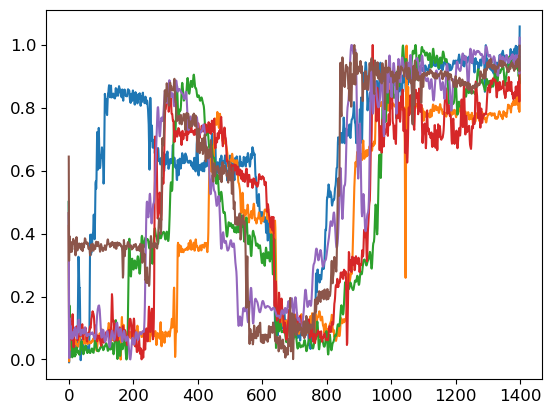

In [53]:
normed = []
for tag in tags:
    # t = np.linspace(0,1,len(tag))
    norm = (tag-np.min(tag))/(np.max(tag)-np.min(tag))
    norm = resample(norm, 1400)
    normed.append(norm)
    plt.plot(norm)

In [54]:
from tslearn.barycenters import softdtw_barycenter
bc = softdtw_barycenter(normed)

In [55]:
prototype = resample(bc, 100)[10:-10]

In [56]:
prototype = (prototype-np.min(prototype))/(np.max(prototype)-np.min(prototype))

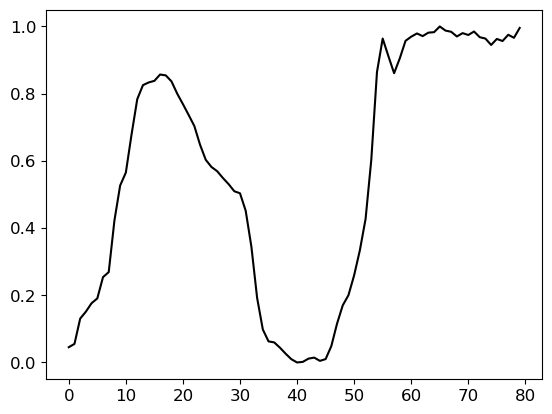

In [57]:
plt.plot(prototype, '-k')

In [9]:
def normalize_trace(y, n_resample=1000):
    # resample the data
    resampled = resample(y,n_resample)
    
    # Smoothen to get rid of spikes
    wlen=10
    kernel = np.full(wlen, 1/wlen)
    smooth = fftconvolve(resampled, kernel)
    
    # Discretize the data to find bins with nsamples > threshold to use for normalization
    disc = np.digitize(smooth, np.linspace(0,1,10))
    ind, counts = np.unique(disc,return_counts=True)
    
    # Find low and high bins
    mincounts = 50
    # find which datapoints are equal to the lowest and highest bins > mincount in one fell swoop
    lo,hi = np.equal(disc[...,None], ind[counts > mincounts][[0,-1]][None,...]).T
    
    # Normalize the smoothed data based on abundant bins
    normmin = np.min(smooth[lo])
    normmax = np.max(smooth[hi])
    
    norm = (smooth-normmin)/(normmax-normmin)
    return norm

In [19]:
@partial
def at_shapelet(t,y, *, shapelet, include=True, mindist=5):
    """
    Try to resample, smoothen and normalize the data as cleanly as possible,
    then find where the shapelet matches the best

    start to give starting index, else ending index
    mindist to consider the shapelet found, can be tuned
    if not found don't yield anything
    """
    norm = normalize_trace(y)
    
    # Calculate DTW alignment to find the best fitting subsequence
    aln = dtw(shapelet, norm, open_end=True, open_begin=True, step_pattern='asymmetric')
    index = aln.index2
    
    # Convert index back to original index
    scl = len(y)/len(norm)
    index = (index*scl).astype(int)
    
    if aln.distance < mindist:
        if include:
            yield t[index[0]:], y[index[0]:]
        else:
            yield t[index[-1]:], y[index[-1]:]

In [64]:
squiggles = Pipeline(
    switch(cutoff=15*fs),
    lowpass(cutoff_fq=100, abf=abf),
    as_ires(minsamples=1000),
    trim(left=0.5*fs, right=0.5*fs),
    at_shapelet(shapelet=prototype, include=True, mindist=5)
)

([], [])

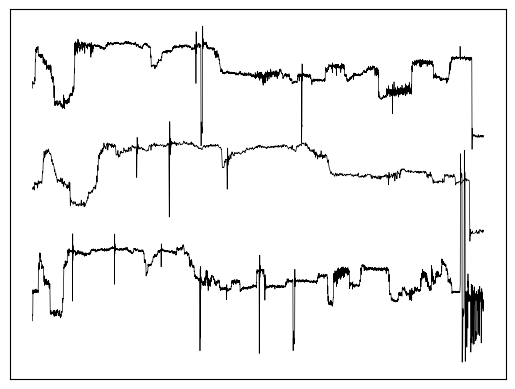

In [65]:
for i, event in enumerate(squiggles(abf).events):
    y = event.y
    t = np.linspace(0,1,len(y))
    # t = event.t
    plt.plot(t,y-1*i,'-k',lw=0.5)
    # break
# plt.ylim((0,1))
plt.yticks([])
plt.xticks([])

[None, None, None]

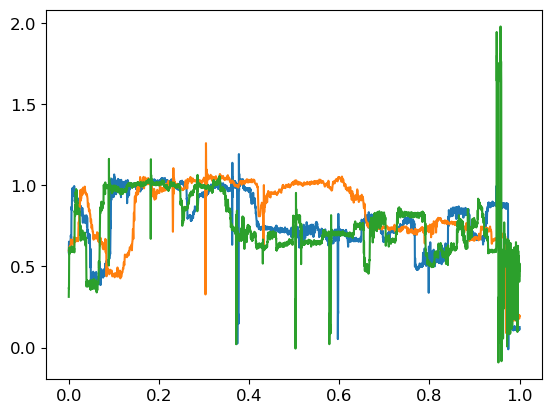

In [66]:
[event.plot(normalize=True) for event in squiggles(abf).events]